<a href="https://colab.research.google.com/github/susan291-gifs/SussieAssignment/blob/main/NeuralNetwork_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

###Problem 1

In [ ]:
class GetMiniBatch:
    """
    Iterator to get a mini-batch

    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
      Training data
    y : ndarray, shape (n_samples,)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random seed
    """
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0] / self.batch_size).astype(int)

    def __len__(self):
        return self._stop

    def __getitem__(self, item):
        p0 = item * self.batch_size
        p1 = item * self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter * self.batch_size
        p1 = self._counter * self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

class ScratchSimpleNeuralNetworkClassifier:
    """
    Simple three-layer neural network classifier

    Parameters
    ----------
    verbose : bool
        Whether to output the learning process

    Attributes
    ----------
    """

    def __init__(self, verbose=True):
        self.verbose = verbose
        self.train_losses = []
        self.val_losses = []

    def _initialize_weights(self, n_features, n_nodes1, n_nodes2, n_output, sigma=0.01):
        self.params = {}
        self.params['W1'] = sigma * np.random.randn(n_features, n_nodes1)
        self.params['b1'] = np.zeros(n_nodes1)
        self.params['W2'] = sigma * np.random.randn(n_nodes1, n_nodes2)
        self.params['b2'] = np.zeros(n_nodes2)
        self.params['W3'] = sigma * np.random.randn(n_nodes2, n_output)
        self.params['b3'] = np.zeros(n_output)

    def _cross_entropy_error(self, Z3, Y):
        batch_size = len(Y)
        return -np.sum(Y * np.log(Z3 + 1e-7)) / batch_size


    def _softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def _cross_entropy_error(self, y_pred, y_true):
        delta = 1e-7
        batch_size = y_pred.shape[0]
        return -np.sum(y_true * np.log(y_pred + delta)) / batch_size

    def _forward(self, X):
        A1 = np.dot(X, self.params['W1']) + self.params['b1']
        Z1 = np.tanh(A1)
        A2 = np.dot(Z1, self.params['W2']) + self.params['b2']
        Z2 = np.tanh(A2)
        A3 = np.dot(Z2, self.params['W3']) + self.params['b3']
        Z3 = self._softmax(A3)
        return Z3, {'Z1': Z1, 'Z2': Z2, 'Z3': Z3}

    def _backward(self, X, y, Z):
        grads = {}
        batch_size = X.shape[0]
        dA3 = (Z['Z3'] - y) / batch_size
        grads['W3'] = np.dot(Z['Z2'].T, dA3)
        grads['b3'] = np.sum(dA3, axis=0)
        dZ2 = np.dot(dA3, self.params['W3'].T)
        dA2 = dZ2 * (1 - np.tanh(Z['Z2']) ** 2)
        grads['W2'] = np.dot(Z['Z1'].T, dA2)
        grads['b2'] = np.sum(dA2, axis=0)
        dZ1 = np.dot(dA2, self.params['W2'].T)
        dA1 = dZ1 * (1 - np.tanh(Z['Z1']) ** 2)
        grads['W1'] = np.dot(X.T, dA1)
        grads['b1'] = np.sum(dA1, axis=0)
        return grads

    def fit(self, X, y, X_val=None, y_val=None, epochs=10, batch_size=20, lr=0.01):
        n_features = X.shape[1]
        n_nodes1 = 400
        n_nodes2 = 200
        n_output = 10

        self._initialize_weights(n_features, n_nodes1, n_nodes2, n_output)

        for epoch in range(epochs):
            get_mini_batch = GetMiniBatch(X, y, batch_size=batch_size, seed=epoch)
            for mini_X_train, mini_y_train in get_mini_batch:
                Z, cache = self._forward(mini_X_train)
                grads = self._backward(mini_X_train, mini_y_train, cache)
                for key in self.params.keys():
                    self.params[key] -= lr * grads[key]

            y_pred_train, _ = self._forward(X)
            train_loss = self._cross_entropy_error(y_pred_train, y)
            self.train_losses.append(train_loss)

            if X_val is not None and y_val is not None:
                y_pred_val, _ = self._forward(X_val)
                val_loss = self._cross_entropy_error(y_pred_val, y_val)
                self.val_losses.append(val_loss)

            if self.verbose:
                print(f'epoch: {epoch+1}, loss: {train_loss:.4f}')

    def predict(self, X):
        Z, _ = self._forward(X)
        return np.argmax(Z, axis=1)


(X_train, y_train), (X_test, y_test) = mnist.load_data()


X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)


X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255


enc = OneHotEncoder(sparse_output=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])


X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(X_train, y_train_one_hot, test_size=0.2)


nn = ScratchSimpleNeuralNetworkClassifier()
nn.fit(X_train, y_train_one_hot, X_val, y_val_one_hot, epochs=10, batch_size=20, lr=0.01)


y_pred = nn.predict(X_test)


accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f'Accuracy on test data: {accuracy:.4f}')

epoch: 1, loss: 0.6588
epoch: 2, loss: 0.3969
epoch: 3, loss: 0.3429
epoch: 4, loss: 0.3191
epoch: 5, loss: 0.2947
epoch: 6, loss: 0.2760
epoch: 7, loss: 0.2609
epoch: 8, loss: 0.2454
epoch: 9, loss: 0.2305
epoch: 10, loss: 0.2216
Accuracy on test data: 0.9324


###Problem 2

In [ ]:
class ForwardPropagation:
    def __init__(self):
        pass

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def tanh(self, x):
        return np.tanh(x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X, W1, b1, W2, b2, W3, b3):
        A1 = np.dot(X, W1) + b1
        Z1 = self.tanh(A1)

        A2 = np.dot(Z1, W2) + b2
        Z2 = self.tanh(A2)

        A3 = np.dot(Z2, W3) + b3
        Z3 = self.softmax(A3)

        return Z3


n_features = 784
n_nodes1 = 400
n_nodes2 = 200
n_output = 10


np.random.seed(0)
W1 = np.random.randn(n_features, n_nodes1)
b1 = np.zeros(n_nodes1)
W2 = np.random.randn(n_nodes1, n_nodes2)
b2 = np.zeros(n_nodes2)
W3 = np.random.randn(n_nodes2, n_output)
b3 = np.zeros(n_output)


batch_size = 20
X = np.random.randn(batch_size, n_features)


forward_propagation = ForwardPropagation()


Z3 = forward_propagation.forward(X, W1, b1, W2, b2, W3, b3)
print("Shape of Z3:", Z3.shape)

Shape of Z3: (20, 10)


###Problem 3

In [ ]:
class ForwardPropagation:
    def __init__(self):
        pass

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def tanh(self, x):
        return np.tanh(x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X, W1, b1, W2, b2, W3, b3):
        A1 = np.dot(X, W1) + b1
        Z1 = self.tanh(A1)

        A2 = np.dot(Z1, W2) + b2
        Z2 = self.tanh(A2)

        A3 = np.dot(Z2, W3) + b3
        Z3 = self.softmax(A3)

        return Z3

    def cross_entropy_error(self, y_true, Z3):
        batch_size = y_true.shape[0]
        return -np.sum(y_true * np.log(Z3 + 1e-7)) / batch_size


forward_propagation = ForwardPropagation()


y_true = np.array([[0, 1, 0],
                    [1, 0, 0],
                    [0, 0, 1]])


Z3 = np.array([[0.1, 0.7, 0.2],
                [0.9, 0.05, 0.05],
                [0.2, 0.2, 0.6]])


error = forward_propagation.cross_entropy_error(y_true, Z3)
print("Cross-entropy error:", error)

Cross-entropy error: 0.3242868875758864


###Problem 4

In [ ]:
class BackPropagation:
    def __init__(self):
        pass

    def sigmoid_derivative(self, A):
        return A * (1 - A)

    def tanh_derivative(self, A):
        return 1 - np.tanh(A)**2

    def backward(self, X, Z1, Z2, Z3, y_true, W2, W3):
        nb_samples = X.shape[0]


        dL_dA3 = (1 / nb_samples) * (Z3 - y_true)


        dL_dB3 = np.sum(dL_dA3, axis=0)


        dL_dW3 = np.dot(Z2.T, dL_dA3)


        dL_dZ2 = np.dot(dL_dA3, W3.T)


        dL_dA2 = dL_dZ2 * self.tanh_derivative(Z2)


        dL_dB2 = np.sum(dL_dA2, axis=0)


        dL_dW2 = np.dot(Z1.T, dL_dA2)


        dL_dZ1 = np.dot(dL_dA2, W2.T)


        dL_dA1 = dL_dZ1 * self.tanh_derivative(Z1)


        dL_dB1 = np.sum(dL_dA1, axis=0)


        dL_dW1 = np.dot(X.T, dL_dA1)

        return {'W1': dL_dW1, 'B1': dL_dB1, 'W2': dL_dW2, 'B2': dL_dB2, 'W3': dL_dW3, 'B3': dL_dB3}


back_propagation = BackPropagation()


X = np.random.rand(20, 784)
Z1 = np.random.rand(20, 400)
Z2 = np.random.rand(20, 200)
Z3 = np.random.rand(20, 10)
y_true = np.random.rand(20, 10)


W2 = np.random.rand(400, 200)
W3 = np.random.rand(200, 10)


gradients = back_propagation.backward(X, Z1, Z2, Z3, y_true, W2, W3)


print("Gradient of loss with respect to W1:", gradients['W1'].shape)

Gradient of loss with respect to W1: (784, 400)


###Problem 5

In [ ]:
class Estimation:
    def __init__(self):
        pass

    def estimate(self, Z3):

        predicted_classes = np.argmax(Z3, axis=1)
        return predicted_classes


estimation = Estimation()


Z3 = np.random.rand(20, 10)


predicted_classes = estimation.estimate(Z3)


print("Predicted classes:", predicted_classes)

Predicted classes: [3 7 9 7 0 6 4 2 3 2 5 7 6 2 1 7 6 6 5 7]


###Problem 6

In [ ]:
nn = ScratchSimpleNeuralNetworkClassifier()


nn.fit(X_train, y_train_one_hot, X_val, y_val_one_hot, epochs=10, batch_size=20, lr=0.01)


y_pred = nn.predict(X_test)


accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f'Accuracy on test data: {accuracy:.4f}')

epoch: 1, loss: 0.6878
epoch: 2, loss: 0.4052
epoch: 3, loss: 0.3453
epoch: 4, loss: 0.3139
epoch: 5, loss: 0.2950
epoch: 6, loss: 0.2698
epoch: 7, loss: 0.2611
epoch: 8, loss: 0.2459
epoch: 9, loss: 0.2312
epoch: 10, loss: 0.2191
Accuracy on test data: 0.9360


###Problem 7

epoch: 1, loss: 0.6675
epoch: 2, loss: 0.4105
epoch: 3, loss: 0.3460
epoch: 4, loss: 0.3164
epoch: 5, loss: 0.2891
epoch: 6, loss: 0.2711
epoch: 7, loss: 0.2564
epoch: 8, loss: 0.2422
epoch: 9, loss: 0.2277
epoch: 10, loss: 0.2204


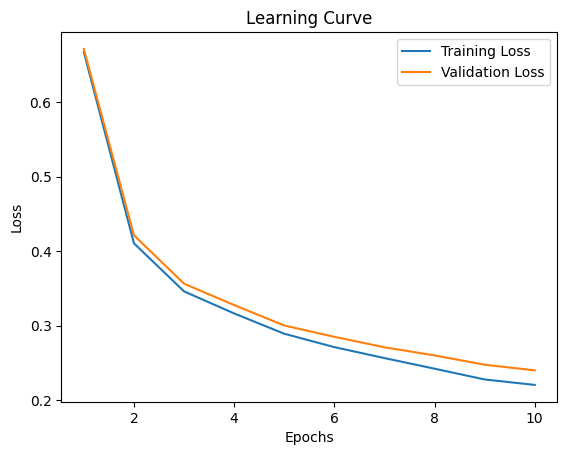

In [ ]:
nn = ScratchSimpleNeuralNetworkClassifier()


nn.fit(X_train, y_train_one_hot, X_val, y_val_one_hot, epochs=10, batch_size=20, lr=0.01)


plt.plot(range(1, 11), nn.train_losses, label='Training Loss')
plt.plot(range(1, 11), nn.val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

###Problem 8 Advance

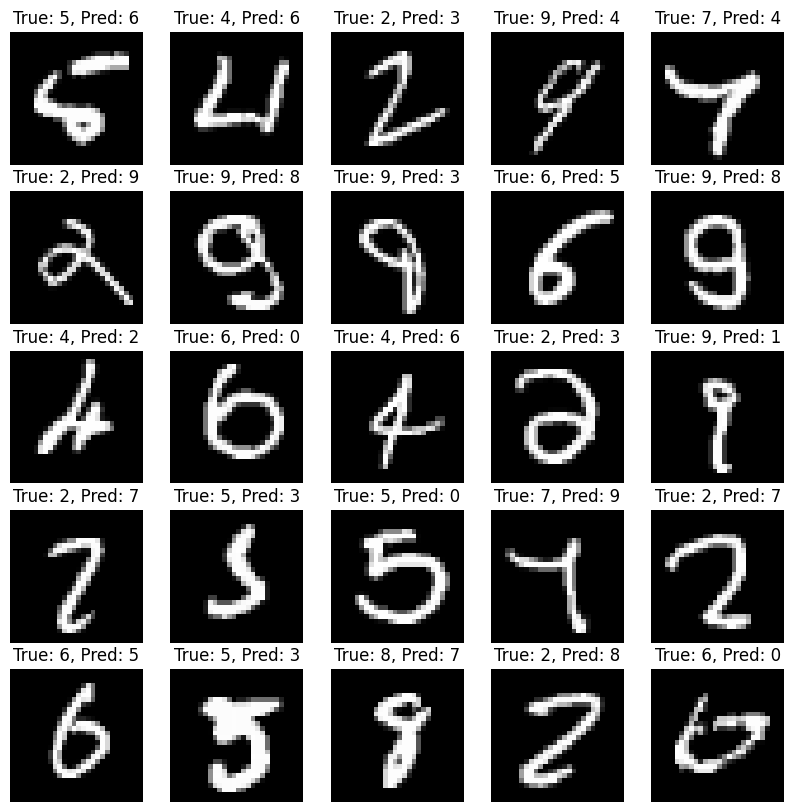

In [ ]:

misclassified_idx = np.where(y_pred != y_test)[0]


plt.figure(figsize=(10, 10))
for i, idx in enumerate(misclassified_idx[:25]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}")
    plt.axis('off')
plt.show()